In [38]:
import os
import sys
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# pytorch
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

# augmentation
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# sci-kit learn
from sklearn.model_selection import StratifiedKFold

# etc
import time


from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

import timm
import gc

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
from numbers import Number
from typing import List
from functools import singledispatch

import numpy as np
import torch

from fastcore.dispatch import typedispatch
from pytorch_lightning import LightningModule
from pytorch_lightning.core.decorators import auto_move_data


from ensemble_boxes import ensemble_boxes_wbf


In [40]:
## Configurations
class CFG:
    mode = 'test'
    seed = 42
    print_freq = 30

    n_class = 1

    img_size = 512

    num_fold = 5
    num_epoch = 50
    batch_size = 8
    num_workers = 8    # decide how many data upload to dataset for a batch
                       # if n_workers 2, dataloader works twice for a batch.
                       # It has impact for cuda memory too

    lr = 0.0002

    max_grad_norm = 1000

    data_dir = './data/testing_images'
    ckpt_dir = './trained_effdet'
    result_dir = './result'
    log_dir = './log'

    csv_dir = './df.csv'
    csv2_dir = './df_kfold.csv'
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
class Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_input = os.listdir(self.data_dir)
        self.lst_input = lst_input
        self.image_id = lst_input
        # [image_id.split('/')[-1][:-4] for image_id in lst_input]    # image_id.jpg에서 .jpg 삭제

    def __len__(self):
        return len(self.lst_input)

    def __getitem__(self, index):
        image_id = self.image_id[index]
        image = cv2.imread(os.path.join(self.data_dir, self.lst_input[index]), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        if self.transform:
            sample = {'image' : image}
            sample = self.transform(**sample)    # 이때까지 해왔던 입력방식은 cv2 이미지를 직접 입력, 여기선 numpy 로 입력
            image = sample['image']

        target = {}
        target['boxes'] = torch.tensor([0.0, 0.0, 0.0, 0.0])
        target['img_scale'] = torch.tensor([1.])
        target['img_class'] = torch.tensor([1.])
        target['img_size'] = torch.tensor([(512, 512)])

            
        return image, target, image_id

In [42]:
def create_model(num_classes=1, image_size=512, architecture="tf_efficientnetv2_l"):
    efficientdet_model_param_dict['tf_efficientnetv2_l'] = dict(
        name='tf_efficientnetv2_l',
        backbone_name='tf_efficientnetv2_l',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )

    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})

    # print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return DetBenchTrain(net, config)

In [43]:
class EfficientDetModel(LightningModule):
    def __init__(
        self,
        num_classes=1,
        img_size=512,
        prediction_confidence_threshold=0.2,
        learning_rate=0.0002,
        wbf_iou_threshold=0.44,
        model_architecture='tf_efficientnetv2_l',
    ):
        super().__init__()
        self.img_size = img_size
        self.model = create_model(
            num_classes, img_size, architecture=model_architecture
        )
        self.prediction_confidence_threshold = prediction_confidence_threshold
        self.lr = learning_rate
        self.wbf_iou_threshold = wbf_iou_threshold
    
    def forward(self, images, targets):
        return self.model(images, targets)

In [44]:
def load_net(ckpt_path):
    net = EfficientDetModel(num_classes=1, img_size=512)

    checkpoint = torch.load(ckpt_path)
    net.load_state_dict(checkpoint)
    
    del checkpoint
    gc.collect()

    return net

In [45]:
def transform_test():
    return A.Compose([A.Resize(height=512, width=512, p=1.0), 
                      A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                      ToTensorV2(p=1.0)], p=1.0)

In [46]:
def test_one_epoch(loader_test, net, score_threshold=0.22):
    net.eval()
    submission = []
    pred_boxes = []

    ##
    for batch, (images, targets, image_ids) in enumerate(loader_test, 1):
        images = torch.stack(images)
        images = images.to(device).float()
        dummy = create_dummy_inference_targets(images.shape[0])
                            
        with torch.no_grad():
           
            det = net(images, dummy)["detections"]
            
            output = []
            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]
                scores = det[i].detach().cpu().numpy()[:,4]
                classes = det[i].detach().cpu().numpy()[:, 5]
                indexes = np.where(scores > score_threshold)[0]
                
                boxes = boxes[indexes]
                output.append({"boxes": boxes, "scores": scores[indexes], "classes": classes[indexes]})

    
        # Weighted Boxes Fusion
        boxes_wbf, scores_wbf, labels_wbf = run_wbf(output, image_size=CFG.img_size, iou_thr=0.44)

        # transform 과정에서 리사이즈된 사진을 원래 크기로 원복함

        # transform 이전에 이미지 사이즈가 필요
        # boxes_wbf에는 img1, img2, img3 ...의 각 bboxes들이 있고
        # bboxes에는 img1의 bboxes들이 있음
        for bboxes, scores, img_id in zip(boxes_wbf, scores_wbf, image_ids):
            
            image = cv2.imread(os.path.join(CFG.data_dir, img_id), cv2.IMREAD_COLOR)
            im_h, im_w = image.shape[1], image.shape[0]

            
            if len(bboxes) > 0:
                bboxes = (np.array(bboxes)*[im_w / CFG.img_size, im_h / CFG.img_size, im_w / CFG.img_size, im_h / CFG.img_size,]).tolist()
                tmp = {'image_id': img_id, 'PredictionString': format_prediction_string(bboxes, scores)}
                pred_boxes.append(bboxes)
            # ?????????????????????????????????????
            else:
                pred_boxes.append(bboxes)

        
            
        # 배치마다 pred에 append 해서 전체 데이터 세트를 만듬
        submission.append(tmp)

    return pred_boxes, submission


In [47]:
def run_wbf(predictions, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    bboxes = []
    confidences = []
    class_labels = []

    for prediction in predictions:
        boxes = [(prediction["boxes"] / image_size).tolist()]

        scores = [prediction["scores"].tolist()]
        labels = [prediction["classes"].tolist()]
        

        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes,
            scores,
            labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )
        boxes = boxes * (image_size - 1)

        
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())
        

    return bboxes, confidences, class_labels

# def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
#     boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
#     scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
#     labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
#     boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
#     boxes = boxes*(image_size-1)
#     return boxes, scores, labels

In [48]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [49]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [50]:
def create_dummy_inference_targets(num_images):
    dummy_targets = {
        "bbox": [
            torch.tensor([[0.0, 0.0, 0.0, 0.0]]).to(device)
            for i in range(num_images)
        ],
        "cls": [torch.tensor([1.0]).to(device) for i in range(num_images)],
        "img_size": torch.tensor(
            [(CFG.img_size, CFG.img_size)] * num_images).to(device).float(),
        "img_scale": torch.ones(num_images).to(device).float(),
    }

    return dummy_targets

In [51]:
def test():
    dataset_test = Dataset(data_dir=CFG.data_dir, transform=transform_test())
    loader_test = DataLoader(dataset_test, batch_size=CFG.batch_size, shuffle=False, num_workers=8, drop_last=False, collate_fn=collate_fn)

    net = load_net(CFG.ckpt_dir)
    net = net.to(device)
    
    pred, sub = test_one_epoch(loader_test, net)


    submission = pd.DataFrame(sub, columns=['image_id', 'PredictionString'])
    submission.to_csv(os.path.join(CFG.result_dir, 'submission.csv'))
    
    return submission, pred


In [52]:
##
if __name__ == "__main__":
    if CFG.mode == "test":
        submission = test()

In [53]:
submission

(          image_id                                   PredictionString
 0  vid_5_26640.jpg  0.5689 271.55802803114057 311.59931732341647 3...,
 [[[271.55802803114057,
    311.59931732341647,
    339.288799026981,
    400.25881602894515],
   [0.460403946635779,
    351.94606677629054,
    32.20625565532828,
    425.90789572149515]],
  []])

In [54]:
torch.cuda.empty_cache()
gc.collect()

298

In [55]:
# visualize a test image
def make_predictions(images, net, score_threshold=0.22):
    net.eval()
    pred_boxes = []
    pred_scores = []
    
    images = torch.stack(images)
    images = images.to(device).float()
    dummy = create_dummy_inference_targets(images.shape[0])

    with torch.no_grad():     
        det = net(images, dummy)["detections"]

        output = []
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]
            scores = det[i].detach().cpu().numpy()[:,4]
            classes = det[i].detach().cpu().numpy()[:, 5]
            indexes = np.where(scores > score_threshold)[0]

            boxes = boxes[indexes]
            output.append({"boxes": boxes, "scores": scores[indexes], "classes": classes[indexes]})
            
        # Weighted Boxes Fusion
        boxes_wbf, scores_wbf, labels_wbf = run_wbf(output, image_size=CFG.img_size, iou_thr=0.44)
       
        pred_scores.append(scores_wbf)
        # transform 과정에서 리사이즈된 사진을 원래 크기로 원복함

        # transform 이전에 이미지 사이즈가 필요
        # boxes_wbf에는 img1, img2, img3 ...의 각 bboxes들이 있고
        # bboxes에는 img1의 bboxes들이 있음
        for bboxes, scores, img_id in zip(boxes_wbf, scores_wbf, image_ids):
            
            image = cv2.imread(os.path.join(CFG.data_dir, img_id), cv2.IMREAD_COLOR)
            im_h, im_w = image.shape[0], image.shape[1]

            
            if len(bboxes) > 0:
                bboxes = (np.array(bboxes)*[im_w / CFG.img_size, im_h / CFG.img_size, im_w / CFG.img_size, im_h / CFG.img_size,]).tolist()
                pred_boxes.append(bboxes)
            # ?????????????????????????????????????
            else:
                pred_boxes.append(bboxes)

    return pred_boxes, pred_scores

In [56]:
dataset_test = Dataset(data_dir=CFG.data_dir, transform=transform_test())
loader_test = DataLoader(dataset_test, batch_size=CFG.batch_size, shuffle=False, num_workers=8, drop_last=False, collate_fn=collate_fn)

images, targets, image_ids = next(iter(loader_test)) # 첫번째 나오는 iteration의 값을 받아준다. 배치가 4기때문에 이미지 아이디도 4개나옴

print(image_ids)

('vid_5_26640.jpg', 'vid_5_26660.jpg')


In [57]:
net = load_net(CFG.ckpt_dir)
net = net.to(device)

[[[483.08743933960795, 175.15937956050038, 603.5769161637872, 224.99755930621177], [0.8190343892783858, 197.83950499258935, 57.29323374474188, 239.41568102687597]], []]
[[[0.5689085125923157, 0.45526859164237976], []]]


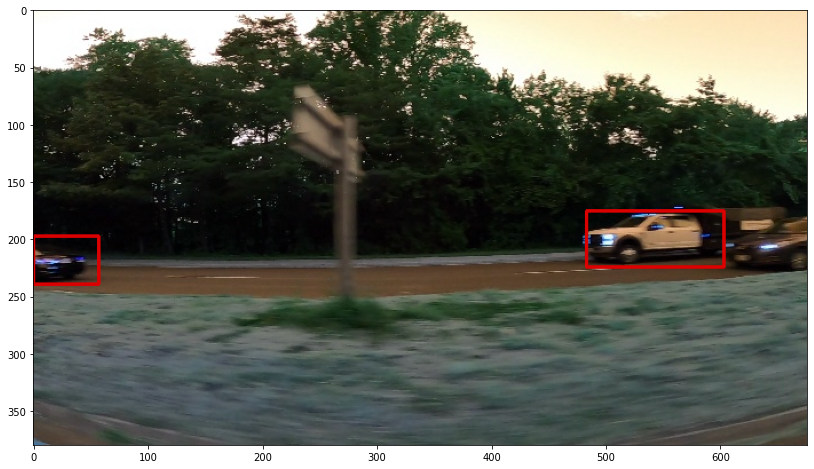

In [58]:
# choose test image idx
idx = 0
sample = cv2.imread(os.path.join(CFG.data_dir, image_ids[idx]), cv2.IMREAD_COLOR)

boxes, scores = make_predictions(images, net, score_threshold=0.22)
boxes_sample = boxes[idx]
# boxes = boxes.astype(np.int32).clip(min=0, max=511) 

print(boxes)
print(scores)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes_sample:
    cv2.rectangle(sample, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (220, 0, 0), 2)
    
ax.imshow(sample)